# Anonymization of the dataset

This notebook performs **full anonymization** of the raw forum dataset. The goal is to ensure that **no identifiable information** remains in the dataset, while preserving metadata useful for analysis.

> ⚠️ **It should be run only once**

## Table of Contents

- [Table of Contents](#table-of-contents)
- [1. Libraries](#libraries)
- [2. Global Variables](#global-variables)
- [3. Load the Dataset](#load-the-dataset)
- [4. Build Mapping Tables](#build-user--topic--msg_id-mapping-tables)
- [5. Basic Anonymization](#basic-anonymisation-in-pandas-cheap-column-ops)
- [6. Detect and Remove Real Usernames in Content](#detect-and-remove-contents-containing-real-usernames)
- [7. Save the Anonymized Dataset](#save-the-anonymized-dataframe)

## Libraries

In [1]:
import hashlib
import re
from pathlib import Path
import matplotlib.pyplot as plt
import math

import pandas as pd
import polars as pl           
from spellchecker import SpellChecker
from tqdm import tqdm
from flashtext import KeywordProcessor
from pandarallel import pandarallel

## Global variables

In [2]:
ROOT            = Path("../..") / "data"
PATH_DATASET    = ROOT / "confidential" / "raw_forum.csv"
PATH_USERS_MAP  = ROOT / "confidential" / "mapping_users.csv"
PATH_TOPICS_MAP = ROOT / "confidential" / "mapping_topics.csv"
PATH_MSG_ID_MAP   = ROOT / "confidential" / "mapping_msg_id.csv"
PATH_SUPPLEMENTARY_WORDS = ROOT / "confidential" / "french_dict_supplementary.txt"
PATH_ANONYM     = ROOT / "anonymous_forum.csv"

In [3]:
spell = SpellChecker(language='fr')
french_words = set(spell.word_frequency.words()) 
print(f"Number of French words: {len(french_words)}")
french_words = french_words.union(set(open(PATH_SUPPLEMENTARY_WORDS, "r", encoding="utf-8").read().splitlines()))
print(f"Adding French words: {len(french_words)}")

Number of French words: 139905
Adding French words: 140198


## Load the dataset

In [4]:
df = pd.read_csv(PATH_DATASET, sep=",", encoding="utf-8", low_memory=False).sample(frac=1, random_state=42)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

Number of rows in the dataset: 1984823
Number of columns in the dataset: 9
Columns in the dataset: ['msg_id', 'user', 'profile_url', 'date', 'content', 'topic', 'topic_url', 'deleted', 'banned']
Number of unique users: 145285
Number of unique topics: 4306
Number of messages with `deleted` status: 992603
Number of messages with `non deleted` status: 992220
Number of unique users with `banned` status: 8117
The column `msg_id` is unique: True


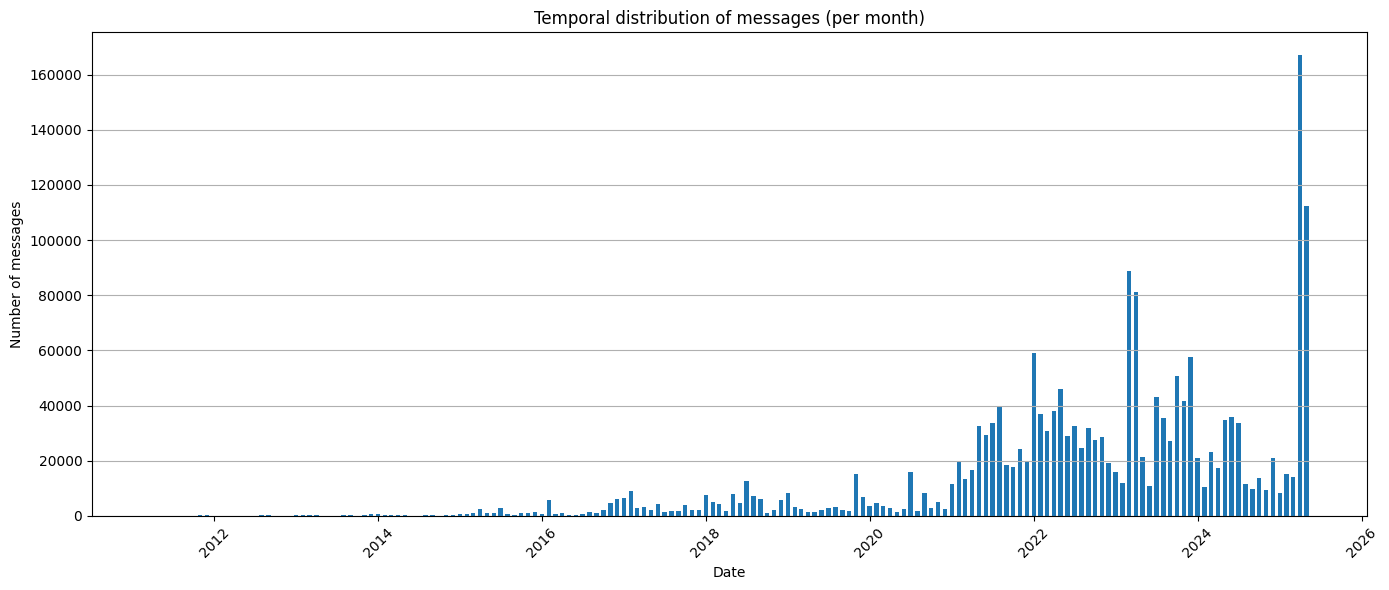

In [5]:
# Print some information about the dataset
print(f"Number of rows in the dataset: {df.shape[0]}")
print(f"Number of columns in the dataset: {df.shape[1]}")
print(f"Columns in the dataset: {df.columns.tolist()}")
print(f"Number of unique users: {df['user'].nunique()}")
print(f"Number of unique topics: {df['topic'].nunique()}")
print(f"Number of messages with `deleted` status: {df['deleted'].sum()}")
print(f"Number of messages with `non deleted` status: {df.shape[0] - df['deleted'].sum()}")
print(f"Number of unique users with `banned` status: {df[df['banned'] == 1]['user'].nunique()}")
print(f"The column `msg_id` is unique: {df['msg_id'].is_unique}")

# Plot the temporal distribution of messages
df_by_month = df.set_index('date').resample('ME').size()
# 3. Plot as barplot
plt.figure(figsize=(14,6))
plt.bar(df_by_month.index, df_by_month.values, width=20)  # width=20 for monthly bars to look nicer
plt.title('Temporal distribution of messages (per month)')
plt.xlabel('Date')
plt.ylabel('Number of messages')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Build user & topic & msg_id mapping tables

In [6]:
def sha_alias(text: str, n: int, prefix: str) -> str:
    """Return `prefix` + first `n` hex chars of SHA-256(text)."""
    return prefix + hashlib.sha256(text.encode("utf-8")).hexdigest()[:n]

def is_real_username(name: str) -> bool:
    """Heuristic: treat as real username if not a French word."""
    return isinstance(name, str) and name.lower() not in french_words

In [7]:
print("Building user mapping …")
users = df["user"].dropna().unique()
mapping_users = {
    u: sha_alias(u, 10, "anon_user_") if is_real_username(u)
       else sha_alias(u, 10, "frenchword_")
    for u in tqdm(users, desc="Users")
}

print("Building topic mapping …")
topics = df["topic"].dropna().unique()
mapping_topics = {
    t: sha_alias(t, 8, "anon_topic_") for t in tqdm(topics, desc="Topics")
}

print("Building msg_id mapping …")
msg_ids = df["msg_id"].dropna().unique()
mapping_msg_ids = {
    m: sha_alias(str(m), 12, "anon_msg_") for m in tqdm(msg_ids, desc="Msg IDs")
}

Building user mapping …


Users: 100%|██████████| 145285/145285 [00:00<00:00, 572966.60it/s]


Building topic mapping …


Topics: 100%|██████████| 4306/4306 [00:00<00:00, 652386.69it/s]


Building msg_id mapping …


Msg IDs: 100%|██████████| 1984823/1984823 [00:03<00:00, 615118.59it/s]


In [8]:
pd.DataFrame.from_dict(mapping_users, orient="index", columns=["anonymous_user"])\
  .rename_axis("original_user").to_csv(PATH_USERS_MAP, encoding="utf-8")
pd.DataFrame.from_dict(mapping_topics, orient="index", columns=["anonymous_topic"])\
  .rename_axis("original_topic").to_csv(PATH_TOPICS_MAP, encoding="utf-8")
pd.DataFrame.from_dict(mapping_msg_ids, orient="index", columns=["anonymous_msg_id"])\
  .rename_axis("original_msg_id").to_csv(PATH_MSG_ID_MAP, encoding="utf-8")

## Basic anonymisation in pandas (cheap column ops)

In [9]:
df["user"]       = df["user"].map(mapping_users)
df["topic"]      = df["topic"].map(mapping_topics)
df["msg_id"] = df["msg_id"].map(mapping_msg_ids)

# Keep only hour of day
df["hour"] = df["date"].dt.hour.astype("Int8")
df = df.drop(columns=["topic_url"])
df = df.drop(columns=["profile_url"])
df = df.drop(columns=["date"])

## Detect and REMOVE contents containing real usernames

In [10]:
# Filter users: keep only real usernames, not French words
users_real = [u for u in users if is_real_username(u)]

print(f"Number of real usernames for content search: {len(users_real)}")

# Now build the KeywordProcessor only on real usernames
kp = KeywordProcessor()
for user in tqdm(users_real, desc="Building Keyword Processor"):
    kp.add_keyword(user)

rows_before = df.shape[0]

def contains_real_username(text):
    if isinstance(text, str):
        return bool(kp.extract_keywords(text))
    return False

df = df[~df["content"].apply(contains_real_username)]

rows_after = df.shape[0]
print(f"Removed {rows_before - rows_after} messages containing real usernames.")

Number of real usernames for content search: 144779


Building Keyword Processor:   0%|          | 0/144779 [00:00<?, ?it/s]

Building Keyword Processor: 100%|██████████| 144779/144779 [00:01<00:00, 130895.73it/s]


Removed 98480 messages containing real usernames.


## Save the anonymized dataframe

In [11]:
df

,msg_id,user,content,topic,deleted,banned,hour
718488,anon_msg_55908da50f0b,anon_user_a5f371a2c3,"La bière ""Urine de Go*"" vient d'arriver.",anon_topic_a181712c,0,0,18
547548,anon_msg_ea38ee1dafc1,anon_user_4264024ed5,Ils ont pris le petit jeune de l'équipe payé a...,anon_topic_3e4caf2b,1,0,12
449689,anon_msg_e340547f803a,anon_user_747ee094dd,Encore bonne chance kheyou,anon_topic_a32635ae,0,0,13
306667,anon_msg_ca8c3a80715a,anon_user_768dcf0a9f,"Non mais ça va aller, les gargouilles le feron...",anon_topic_2e39b13d,1,0,18
646980,anon_msg_f2279e23f198,anon_user_f3ac5bb79a,Comme mercredi hein\nLes cliqueurs dans le déni,anon_topic_eb025aee,1,0,17
...,...,...,...,...,...,...,...
259178,anon_msg_0d3a29e99bcc,anon_user_48fc278598,Comment la défense aérienne russe n’a pas pu l...,anon_topic_8aa5af54,0,0,15
1414414,anon_msg_317b9332011e,anon_user_9fab091e9c,Ma vie pue la merde ça m'occupe,anon_topic_2cf4c5b2,1,0,10
131932,anon_msg_c5f4d2ae5dd6,anon_user_acb54aac5c,Joli reverse tutorial,anon_topic_15083744,0,0,11
671155,anon_msg_ce16c9480acc,anon_user_38fa649bec,"Cocasse, quand on sait qu'il se vante toujours...",anon_topic_41fc3e02,1,0,17


In [12]:
df.to_csv(PATH_ANONYM, sep=",", encoding="utf-8", index=False)